# IBM AI Capstone Project - Part 1

1. Assimilate the business scenario and articulate testable hypotheses.

Business Scenario:
AAVAIL has conducted an experiment outside of US where it followed an à la carte service delivery approach. Ther users were charged only for the services they availed/used. 

The management has decided to roll out à la carte service to its customers and it needs a model to predict monthly revenue. The data science team need to create a service that, at any point in time, will predict the revenue for the following month.

The service should have the ability to project revenue for a specific country. To keep the development time reasonable data science team has been advised to limit the model to the ten most revenue generating countries.

At present the managers at AAVAIL are using their own methods to predict revenue. However, the management feels that the current manual process is time consuming and lacks accuracy. Management needs data science team to help build models which are more accurate.

Testable hypothesis: 
We will start with the hypotheses that the increase in the accuracy of revenue prediction has no impact on overall revenue.

2. State the ideal data to address the business opportunity and clarify the rationale for needing specific data.

Customer transactional data which would identify the customer and the transaction carried out i.e customer identifier, country or location, content viewed, subscription plan etc. As evident from business case, the target wpuld be revenue prediction.

3. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.

In [1]:
#import relevant libraries
import os
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#ingest data using the functions available in cslib module which was made available with this solution
from cslib import *

I am using the function fetch_data available in cslib module which was provided with this solution to fetch data from the source. The function fetch_data incorporates the following quality checkes:
Input testing - Checks for the availaility of data directory. Throws error, if not found.
Data formatting with correct columns which includes handling of inconsistent columns
Returns a dataframe

In [3]:
#fetch relevant data

base_dir = 'C:/Users/RandhirJaiswal/AI Workflow Last Module AI in Prod/CapstoneFinal'
run_start = time.time()
#data_dir = os.path.join("..","data","cs-train")
data_dir = os.path.join(base_dir,"data","cs-train")
print("...fetching data")

df_raw = fetch_data(data_dir)

m, s = divmod(time.time()-run_start,60)
h, m = divmod(m, 60)
print("load time:", "%d:%02d:%02d"%(h, m, s))

...fetching data
load time: 0:00:10


4. Investigate the relationship between the relevant data, the target and the business metric.

In [4]:
df_raw.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [5]:
#Check data type of columns in dataframe
df_raw.dtypes

country                 object
customer_id            float64
day                      int64
invoice                 object
month                    int64
price                  float64
stream_id               object
times_viewed             int64
year                     int64
invoice_date    datetime64[ns]
dtype: object

In [6]:
#get the number of rows and columns in the dataframe
df_raw.shape

(815011, 10)

In [7]:
#Check for missing values in dataframe
df_raw.isnull().sum()

country              0
customer_id     189762
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64

In [8]:
df_raw.describe()

,customer_id,day,month,price,times_viewed,year
count,625249.000000,815011.000000,815011.000000,815011.000000,815011.000000,815011.000000
mean,15333.415068,15.064819,6.592718,4.802631,5.231106,2018.247654
std,1698.360788,8.788845,3.598781,135.058707,5.109982,0.545261
min,12346.000000,1.000000,1.000000,-53594.360000,0.000000,2017.000000
25%,13956.000000,7.000000,3.000000,1.250000,1.000000,2018.000000
50%,15279.000000,15.000000,6.000000,2.100000,3.000000,2018.000000
75%,16813.000000,23.000000,10.000000,4.210000,8.000000,2019.000000
max,18287.000000,31.000000,12.000000,38970.000000,24.000000,2019.000000


Creating a temp dataframe to hold all the invoice ids which have letters to be removed for improved matching.

In [10]:
temp_df = df_raw[df_raw['invoice'].str.contains("[a-zA-Z]")]

In [11]:
temp_df

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date


Temp dataframe is empty which means none of the invoice ids contain letter.

In [12]:
ts_df = convert_to_ts(df_raw)

In [13]:
ts_df.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.0
1,2017-11-02,0,0,0,0,2017-11,0.0
2,2017-11-03,0,0,0,0,2017-11,0.0
3,2017-11-04,0,0,0,0,2017-11,0.0
4,2017-11-05,0,0,0,0,2017-11,0.0


In [14]:
ts_df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
602    False
603    False
604    False
605    False
606    False
Length: 607, dtype: bool

In [16]:
print("Total records:", df_raw.shape[0])
dupl_records = df_raw.duplicated()
if True in dupl_records:
    df_updated = df_raw[~dupl_records]
print("Deleted {} duplicate rows".format(np.where(dupl_records==True)[0].size))

print("\nCount of missing data values\n")
print(df_updated.isnull().sum(axis = 0))

Total records: 815011
Deleted 28844 duplicate rows

Count of missing data values

country              0
customer_id     182194
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64


In [17]:
#Create a pivot table of 10 most and 10 least revenue generating countries
table = pd.pivot_table(df_raw,index='country',values="price",aggfunc='sum')
table.columns = ['total_revenue']
table.sort_values(by='total_revenue',inplace=True,ascending=False)
top_ten_countries =  np.array(list(table.index))[:10]
bottom_ten_countries =  np.array(list(table.index))[-10:]
print ("\n Top 10 revenue generating countries are:", top_ten_countries)
print ("\n Bottom 10 revenue generating countries are:", bottom_ten_countries)


 Top 10 revenue generating countries are: ['United Kingdom' 'EIRE' 'Germany' 'France' 'Norway' 'Spain' 'Hong Kong'
 'Portugal' 'Singapore' 'Netherlands']

 Bottom 10 revenue generating countries are: ['Lebanon' 'European Community' 'Brazil' 'Thailand' 'Korea' 'West Indies'
 'Nigeria' 'Bermuda' 'Czech Republic' 'Saudi Arabia']


In [18]:
#revenue generated by top 10 countries
table[:10]

,total_revenue
country,
United Kingdom,3.521514e+06
EIRE,1.070692e+05
Germany,4.927182e+04
France,4.056514e+04
Norway,3.849475e+04
Spain,1.604099e+04
Hong Kong,1.445257e+04
Portugal,1.352867e+04
Singapore,1.317592e+04


In [19]:
#revenue generated by bottom 10 countries
table[-10:]

,total_revenue
country,
Lebanon,358.61
European Community,294.05
Brazil,256.31
Thailand,227.97
Korea,150.24
West Indies,122.77
Nigeria,109.28
Bermuda,84.70
Czech Republic,31.83


In [20]:
top_ten_countries = ["United Kingdom","EIRE","Germany","France","Norway","Spain","Hong Kong","Portugal","Singapore","Netherlands"]

Text(0, 0.5, 'total_revenue')

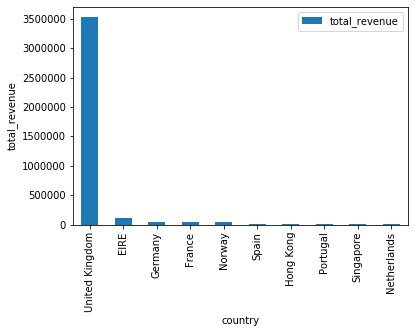

In [21]:
#Bar chart of top 10 revenue generating countries
top_rev_countries = table.query('country == ["United Kingdom","EIRE","Germany","France","Norway","Spain","Hong Kong","Portugal","Singapore","Netherlands"]')
top_rev_countries.plot(kind= 'bar')
plt.ylabel("total_revenue")

Text(0, 0.5, 'total_revenue')

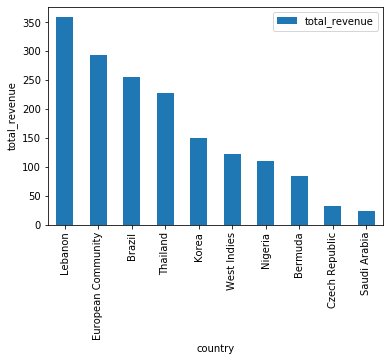

In [22]:
#Bar chart of 10 least revenue generating countries
bottom_rev_countries = table.query('country == ["Lebanon","European Community","Brazil","Thailand","Korea","West Indies","Nigeria","Bermuda","Czech Republic","Saudi Arabia"]')
bottom_rev_countries.plot(kind= 'bar')
plt.ylabel("total_revenue")

In [23]:
df_top_ten = df_raw[df_raw['country'].isin(top_ten_countries)]
df_top_ten.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


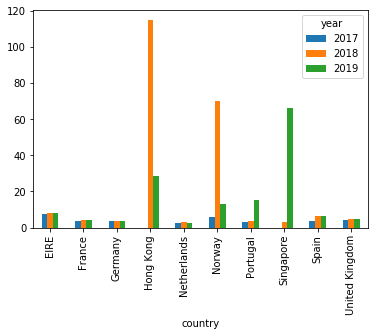

In [24]:
#Create a bar chart to depict average price by country for each year i.e. 2017, 2018 and 2019
table_by_price = pd.pivot_table(df_top_ten,index='country',columns='year',values="price")
table_by_price.plot(kind='bar')

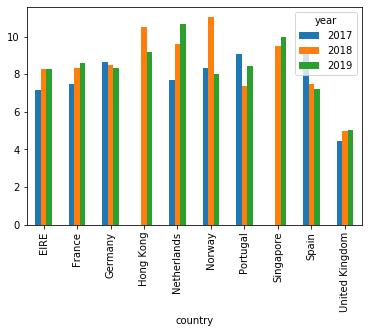

In [25]:
#Create a bar chart to depict average times_viewed by country for each year i.e. 2017, 2018 and 2019
table_by_view = pd.pivot_table(df_top_ten,index='country',columns='year',values="times_viewed")
table_by_view.plot(kind='bar')

5. Articulate your findings using a deliverable with visualizations.

I am using the convert_to_ts function available in cslib module to transform the the original DataFrame to a numerically indexed time-series DataFrame by aggregating over each day.

Target variable: revenue

In [26]:
df_ts = convert_to_ts(df_raw)

In [27]:
df_ts.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.0
1,2017-11-02,0,0,0,0,2017-11,0.0
2,2017-11-03,0,0,0,0,2017-11,0.0
3,2017-11-04,0,0,0,0,2017-11,0.0
4,2017-11-05,0,0,0,0,2017-11,0.0


In [28]:
df_ts_rev_views = df_ts.loc[:, ['date','revenue','total_views']]

In [29]:
df_ts_rev = df_ts_rev_views['revenue']
df_ts_views = df_ts_rev_views['total_views']

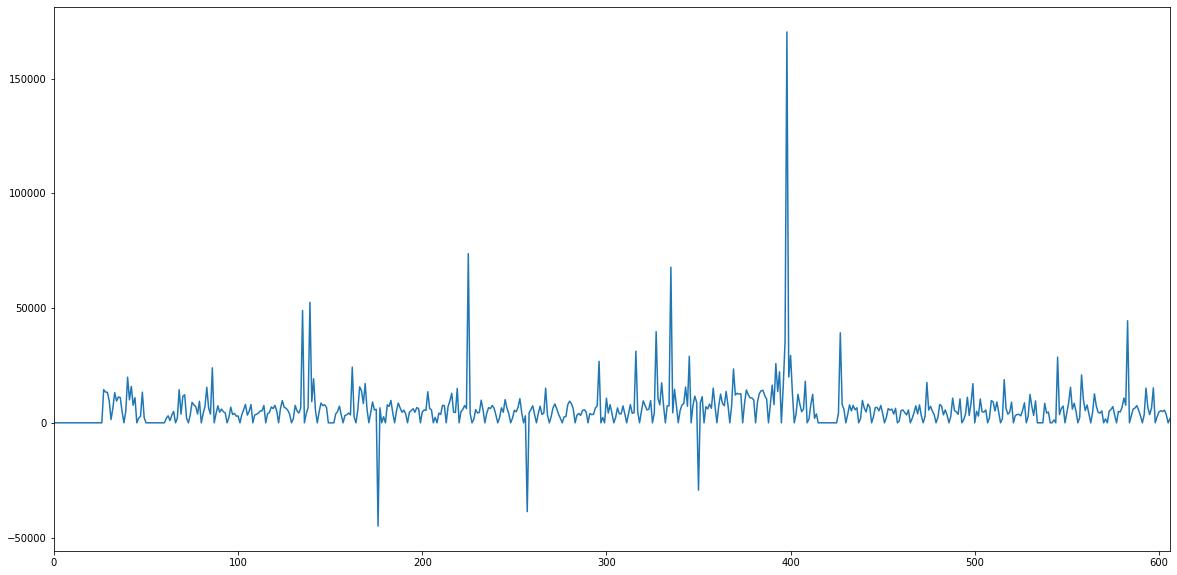

In [30]:
#time series plot of revene on a daily basis
plt.figure(figsize=(20,10))
df_ts_rev.plot()
plt.show()

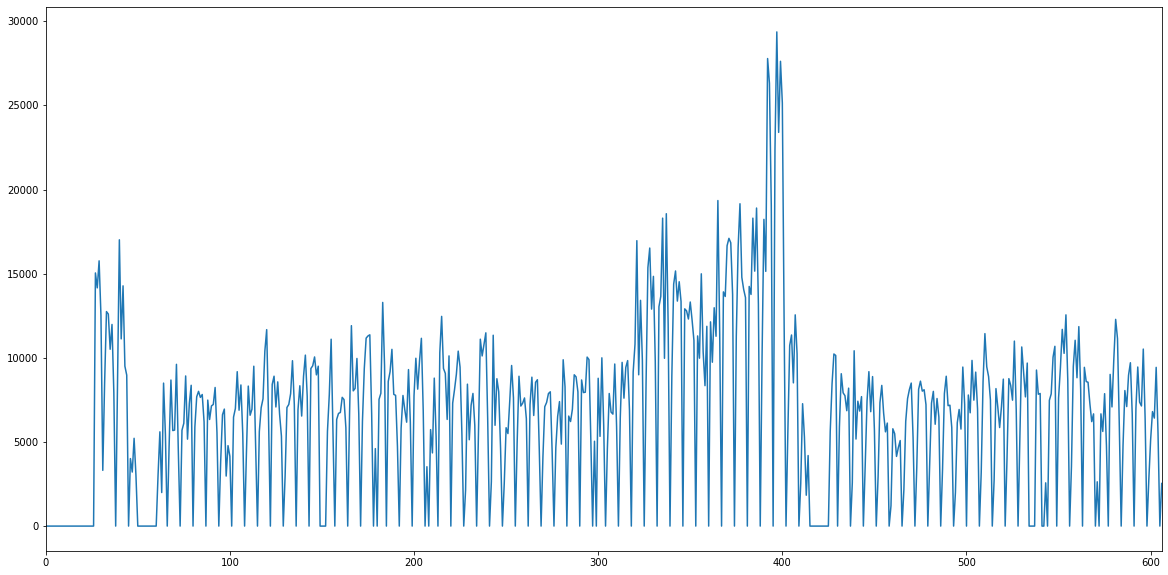

In [31]:
#time series plot of total views on a daily basis
plt.figure(figsize=(20,10))
df_ts_views.plot()
plt.show()